# Multi-Layer Pereceptron with Regularization


## Srujan Esanakarra

### October 28, 2021

# Initialization

## Dependencies

In [31]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install sklearn

## Import Libraries

In [142]:
import numpy as np
import random
import pandas as pd
import seaborn as sns
from itertools import chain
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
%matplotlib inline

# Create Data

Curated 2D data for three different classes

In [143]:
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = random.randint(0,1)
    x2 = random.randint(0,1)
    if x1 == 1 and x2 == 0:
        y = 0
    elif x1 == 0 and x2 == 1:
        y = 0
    elif x1 == 0 and x2 == 0:
        y = 1
    else:
        y = 2
    x1 = 1.0 * x1 + 0.20 * np.random.normal()
    x2 = 1.0 * x2 + 0.20 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = y
    
for i in range(int(0.25 *len(data.index))):
    k = np.random.randint(len(data.index)-1)  
    data.iloc[k,0] = 1.5 + 0.20 * np.random.normal()
    data.iloc[k,1] = 1.5 + 0.20 * np.random.normal()
    data.iloc[k,2] = 1

for i in range(int(0.25 *len(data.index))):
    k = np.random.randint(len(data.index)-1)  
    data.iloc[k,0] = 0.5 + 0.20 * np.random.normal()
    data.iloc[k,1] = -0.75 + 0.20 * np.random.normal()
    data.iloc[k,2] = 2
    
# Now let's normalize this data.
data.iloc[:,0] = (data.iloc[:,0] - data['x1'].mean()) / data['x1'].std()
data.iloc[:,1] = (data.iloc[:,1] - data['x2'].mean()) / data['x2'].std()
        
data.head()

,x1,x2,y
0,-1.165422,-0.458896,1.0
1,0.446394,-0.770184,0.0
2,-0.582607,-1.022132,2.0
3,-1.609689,-0.545668,1.0
4,0.527733,-0.291855,0.0


In [144]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them 
X = np.array(X.values)
y = np.array(y.values)

Plot function

In [145]:
# Function for plotting data
def plot_data(X, y_predict):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    indices_0 = [k for k in range(0, X.shape[0]) if y_predict[k] == 0]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k] == 1]
    indices_2 = [k for k in range(0, X.shape[0]) if y_predict[k] == 2]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')
    ax.plot(X[indices_2, 0], X[indices_2,1], marker='o', linestyle='', ms=5, label='2')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Tricky 3 Class Classification')
    plt.show()

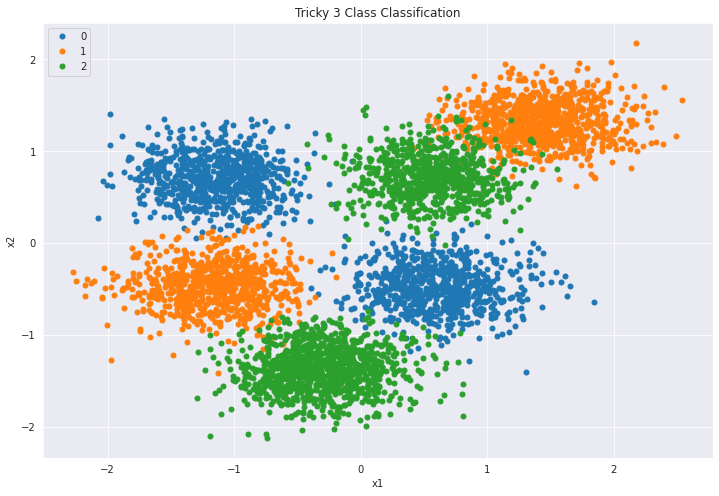

In [146]:
plot_data(X, y)

# Network

## Base Class

In [147]:
class Layer:
  """
  Base class for all layers in the netwrok with placeholder methods for 
  initialization, forward propagation, and back propagation
  """


  def __init__(self):
    """
    Initialization
    """
    pass

  
  def forward(self, X, *args, **kwargs):
    """
    Forward propagation
    X: input
    Simply returns the input in the base class 
    """
    return X

  
  def backward(self, X, gradient):
    """
    Back propagation
    X: input
    gradient: gradient from next layer to propagate through this layer
    Simply returns the gradient in the base class
    """
    num_units = X.shape[1]
    # identity matrix
    dX = np.eye(num_units)

    return np.dot(gradient, dX)

## ReLU Class

In [148]:
class ReLU(Layer):
  """
  ReLU class extends Layer class and is used as the activation function for
  the hidden layers' outputs
  """


  def __init__(self):
    """
    ReLU has no parameters to be initialized
    """
    pass
  

  def forward(self, X):
    """
    'Forward propagation' - applies activation function to previous layer
    outputs
    X: previous layer outputs
    Returns element wise application of ReLU function
    """
    return np.maximum(0, X)
  
  
  def backward(self, X, gradient):
    """
    'Back propagation' - derivative of ReLU
    X: output from previous layer
    gradient: gradient from next layer to propagate
    """
    grad_relu = np.where(X >= 0, 1, 0)
    return np.multiply(gradient, grad_relu)

## LeakyReLU Class

In [149]:
class LeakyReLU(Layer):
  """
  LeakyReLU class extends Layer class and is used as the activation function for
  the hidden layers' outputs; multiplies negative values by 0.05 rather than 0
  """


  def __init__(self):
    """
    LeakyReLU has no parameters to be initialized
    """
    pass

  
  def forward(self, X):
    """
    'Forward propagation' - applies activation function to previous layer
    outputs
    X: previous layer outputs
    Returns element wise application of LeakyReLU function
    """
    return np.maximum(0.05 * X, X)
  

  def backward(self, X, gradient):
    """
    'Back propagation' - derivative of LeakyReLU
    X: output from previous layer
    gradient: gradient from next layer to propagate
    """
    grad_leaky_relu = np.where(X >= 0, 1, 0.05)
    return np.multiply(gradient, grad_leaky_relu)

## HiddenLayer Class

In [150]:
class HiddenLayer(Layer):
  """
  HiddenLayer class extends Layer class
  Implementation of a HiddenLayer with hidden units and incoming and outgoing
  connections
  """


  def __init__(self, dim_in, dim_out, learning_rate):
    """
    Initialization
    dim_in: number of units in previous layer
    dim_out: number of units in this layer
    learning_rate: scale for parameter updates
    """
    self.dim_in = dim_in
    self.dim_out = dim_out
    self.lr = learning_rate

    # initialization of weights and biases for this layer using 
    # Xavier initialization
    self.W = np.random.normal(loc=0.0, scale=np.sqrt(2/(self.dim_in + 
                                                              self.dim_out)), 
                                    size=(self.dim_in, self.dim_out))
    self.b = np.zeros((1, dim_out))

  
  def set_regularization_vals(self, val, bsize):
    """
    Set Regularization Parameter
    val: value
    """
    self.reg = val
    self.batch_size = bsize
  
  
  def forward(self, X):
    """
    Forward propagation
    X: outputs from previous layer; if previous is a hidden layer, 
    activated outputs
    Returns current layer values, calculated as a product of outputs 
    from previous layer and current layer weights
    """
    return np.dot(X, self.W) + self.b
  

  def backward(self, X, gradient):
    """
    Back propagation
    X: outputs from previous layer; if previous is a hidden layer,
    activated outputs
    gradient: calculated gradient from next layer to propagate
    Returns product of gradient and current layer weights to propagate through
    previous layer
    """
    grad_X = np.dot(gradient, self.W.T)

    # values to update weights and biases with gradient
    grad_W = np.dot(X.T, gradient)
    grad_b = np.sum(gradient, axis=0, keepdims = True)

    # verify calculations by matching expected shapes
    assert grad_W.shape == self.W.shape and grad_b.shape == self.b.shape

    # regularization to prevent overfitting
    grad_W += (self.reg * self.W) / self.batch_size

    # update weights and biases
    self.W -= self.lr * grad_W
    self.b -= self.lr * grad_b

    return grad_X

## OutputLayer Class

In [151]:
class OutputLayer(Layer):
  """
  OutputLayer class extends Layer class
  Implementation of the OutputLayer with output units and connections from
  the last HiddenLayer
  """


  def __init__(self, dim_in, dim_out, learning_rate):
    """
    Initialization
    dim_in: number of units in last HiddenLayer
    dim_out: number of output classes
    learning_rate: scale for parameter updates
    """
    self.dim_in = dim_in
    self.dim_out = dim_out
    self.lr = learning_rate

    # initialization of weights and biases for this layer using 
    # Xavier initialization
    self.W = np.random.normal(loc=0.0, scale=np.sqrt(2/(self.dim_in + 
                                                              self.dim_out)), 
                                    size=(self.dim_in, self.dim_out))
    self.b = np.zeros((1, dim_out))

  
  def set_regularization_vals(self, val, bsize):
    """
    Set Regularization Parameter
    val: value
    """
    self.reg = val
    self.batch_size = bsize


  def forward(self, X):
    """
    Forward propagation
    X: outputs from last HiddenLayer
    Returns linear output values, calculated as a product of outputs 
    from last HiddenLayer and current layer weights
    """
    return np.dot(X, self.W) + self.b
  

  def backward(self, X, gradient):
    """
    Back propagation
    X: outputs from last HiddenLayer
    gradient: gradient of loss function to propagate
    Returns product of gradient and current layer weights to propagate through
    previous layers
    """
    grad_X = np.dot(gradient, self.W.T)

    # values to update weights and biases with gradient
    grad_W = np.dot(X.T, gradient)
    grad_b = np.sum(gradient, axis=0, keepdims = True)

    # verify calculations by matching expected shapes
    assert grad_W.shape == self.W.shape and grad_b.shape == self.b.shape

    # regularization to prevent overfitting
    grad_W += (self.reg * self.W) / self.batch_size

    # update weights and biases
    self.W -= self.lr * grad_W
    self.b -= self.lr * grad_b

    return grad_X

## LossLayer Class

In [152]:
class LossLayer(Layer):
  """
  LossLayer class extends Layer class
  Implementation of the softmax cross entropy loss function
  """


  def __init__(self, dim_in, dim_out):
    """
    Initialization
    dim_in: number of outputs
    dim_out: number of softmax outputs
    """
    self.dim_in = dim_in
    self.dim_out = dim_out
  

  def set_values(self, y):
    """
    Set values to be used in loss calculation; regularization will be added
    in MLP class
    y: one-hot encoded labels for data
    """
    self.y = y


  def softmax(self, output_array):
    """
    Softmax
    Apply the softmax function to the linear outputs from the output layer
    Return outputs with softmax applies
    """
    logits_exp = np.exp(output_array)
    return logits_exp / np.sum(logits_exp, axis=1, keepdims=True)
  

  def forward(self, X):
    """
    'Forward propagation' - calculate loss for this batch
    X: outputs from output layer
    Returns loss for this batch
    """
    softmax_outputs = self.softmax(X)
    # determine which output class has the highest probability
    indices = np.argmax(softmax_outputs, axis=1).astype(int)
    # create array containing highest probability output for each data point
    predicted_probs = softmax_outputs[np.arange(len(X)), indices]
    # take element-wise log of the previous array
    log_preds = np.log(predicted_probs)
    # calculate total loss for the batch
    loss = -1.0 * np.sum(log_preds) / len(log_preds)

    return loss

  
  def backward(self, X, gradient=None):
    """
    'Back propagation' - derivative of softmax cross entropy loss to propagate
    X: outputs from output layer
    Returns gradient to propagate through the network
    """
    softmax_outputs = self.softmax(X)
    grad = (softmax_outputs - self.y) / softmax_outputs.shape[0]

    return grad

## MLP

In [180]:
class MLP:
  """
  MLP class implements the neural network for a multi-class, multi-layer
  perceptron with all the required methods to set network structure, train
  network, and predict classifications
  """


  def __init__(self):
    """
    Initialization
    """
    # list to hold all the layers of the network
    self.layers = []
    # default learning rate
    self.learning_rate = 0.01

  
  def set_learning_rate(self, lr):
    """
    Set learning rate for the network
    lr: learning rate value
    """
    self.learning_rate = lr


  def add_layer(self, type, dim_in, dim_out):
    """
    Add layer to network
    type: type of layer to add to network
    dim_in: number of input units
    dim_out: number of output units
    """
    if type == 'Hidden':
      # append list of layers with HiddenLayer object and ReLU object for
      # activation
      self.layers.append(HiddenLayer(dim_in, dim_out, self.learning_rate))
      self.layers.append(ReLU())
    elif type == 'Output':
      # append list of layers with OutputLayer object; softmax is used for
      # predictions and loss function
      self.layers.append(OutputLayer(dim_in, dim_out, self.learning_rate))
    elif type == 'Loss':
      # append list of layers with LossLayer object
      self.layers.append(LossLayer(dim_in, dim_out))


  def forward(self, X, predict=False):
    """
    Forward propagation through the entire network once
    X: training data for the network
    predict: if True, skips propagating through the LossLayer
    Returns outputs of each layer in the network as a list
    """
    # list of outputs from each layer
    self.activations = []
    # input training data
    input = X

    if predict:
      # skip propagating through the LossLayer
      for layer in self.layers[:-1]:
        # add outputs from current layer to list of activations
        self.activations.append(layer.forward(input))
        # set input to latest outputs to propagate through next layer
        input = self.activations[-1]
    else:
      for layer in self.layers:
        # add outputs from current layer to list of activations
        self.activations.append(layer.forward(input))
        # set input to latest outputs to propagate through next layer
        input = self.activations[-1]
    
    # check network performance by testing expected shapes
    if predict:
      assert len(self.activations) == len(self.layers[:-1])
    else:
      assert len(self.activations) == len(self.layers)

    return self.activations

  
  def backward(self, layer_inputs, gradient):
    """
    Back propagation through the entire network once
    layer_inputs: contains inputs for each layer in the network, except the 
                  LossLayer
    gradient: calculated gradient of loss function to back propagate through
              the network
    """
    grad = gradient
    # back propagate through each layer, except LossLayer
    for idx in range(len(self.layers))[:-1][::-1]:
      layer = self.layers[idx]
      # propagate gradient and update it for each layer
      grad = layer.backward(layer_inputs[idx], grad)

  
  def softmax(self, output_array):
    """
    Softmax function
    output_array: outputs from OutputLayer
    Returns outputs with softmax applied
    """
    logits_exp = np.exp(output_array)
    return logits_exp / np.sum(logits_exp, axis=1, keepdims = True)
  

  def regularization_L2(self, val, layers):
    """
    L2 regularization
    val: lambda parameter for regularization
    layers: Layer objects for the network
    Returns regularization component of loss
    """
    reg_loss = 0
    for layer in layers:
      # calculate regularization component of loss for layers with weights
      if isinstance(layer, HiddenLayer) or isinstance(layer, OutputLayer):
        reg_loss += 0.5 * val * np.sum(layer.W * layer.W)
    return reg_loss

  
  def predict(self, X):
    """
    Predict classes for given data
    X: test data
    Returns labels for given data
    """
    outputs = self.forward(X, predict=True)[-1]
    softmax_outputs = self.softmax(outputs)

    return np.argmax(softmax_outputs, axis=1).astype(int)

  
  def shuffle(self, X, y):
    """
    Shuffle
    X: values to be shuffled
    y: labels to be shuffled
    Generates a random order to shuffle the data
    Returns shuffled data
    """
    order = np.random.permutation(len(X))
    return X[order], y[order]
  
  
  def _index(self, arr, indices):
    """
    Index
    Function to return sub-array from array and indices
    arr: array from which indices have to be obtained
    indices: indices to be obtained
    Returns sub-array from given array and indices
    """
    if hasattr(arr, 'shape'):
        return arr[indices]
    
    return [arr[idx] for idx in indices]
  
  
  def train_test_split(self, *arrays, test_size=0.2, shuffle=True, random_seed=1):
    """
    Train Test Split
    Function to split inputted arrays into training and test sets
    arrays: arrays to split into training and test sets
    test_size: size of test set in range (0,1)
    shuffle: shuffle arrays, yes or no
    random_seed: random seed value
    Returns 2*len(arrays) divided into training and test sets
    """
    assert 0 < test_size < 1
    assert len(arrays) > 0
    length = len(arrays[0])
    for i in arrays:
        assert len(i) == length

    test_count = int(np.ceil(length*test_size))
    train_count = length - test_count

    if shuffle:
        perm = np.random.RandomState(random_seed).permutation(length)
        train_indices = perm[test_count:]
        test_indices = perm[:test_count]
    else:
        train_indices = np.arange(train_count)
        test_indices = np.arange(train_count, length)

    return list(chain.from_iterable((self._index(arr, train_indices), 
                                     self._index(arr, test_indices)) for arr in arrays))
    
    
  def encoding(self, y, c):
    """
    One-hot encoding of labels
    y: labels
    c: number of classes
    Returns one-hot encoded labels
    """
    y = y.astype(int)
    labels_onehot = np.zeros((y.shape[0], c)).astype(int)
    for x in range(len(y)):
      labels_onehot[x, y[x]] = 1

    return labels_onehot

  
  def minibatches(self, X, y, shuffle=True):
    """
    Split data into minibatches
    X: input data
    y: labels
    shuffle: if True, shuffles the data before splitting
    Returns generator with minibatches of given data
    """
    assert len(X) == len(y)

    if shuffle:
      X_s, y_s = self.shuffle(X, y)
    
    for start in range(0, len(X), self.batch_size):
      stop = start + self.batch_size
      if shuffle:
        X_batch = X_s[start:stop]
        y_batch = y_s[start:stop]
      else:
        X_batch = X[start:stop]
        y_batch = y[start:stop]
      yield X_batch, y_batch
  
  
  def _train(self, X, y):
    """
    Helper method to train network with a given minibatch
    X: minibatch input data
    y: minibatch labels
    Returns loss for minibatch
    """
    assert isinstance(self.layers[-1], LossLayer)
    # set expected labels in LossLayer
    self.layers[-1].set_values(y)

    # outputs from each layer of the network
    activations = self.forward(X)

    outputs = activations[-2]
    loss = activations[-1]

    # calculate gradient of loss
    grad_loss = self.layers[-1].backward(outputs)
    # add original input data to outputs from each layer (except LossLayer) 
    # to create list of inputs for each layer
    layer_inputs = [X]+activations[:-1]

    # back propagation
    self.backward(layer_inputs[:-1], grad_loss)

    return loss

  
  def train(self, X, y, epochs=100, bsize=8, alpha=0.0, early_stopping=False):
    """
    Train the network
    X: data
    y: labels
    epochs: number of iterations to train the network
    bsize: batch size for minibatches
    alpha: regularization parameter
    Returns losses by epoch after training the network
    """
    self.X = X
    self.y_orig = y
    self.y = self.encoding(y, 3) # one-hot encoding for labels
    self.epochs = epochs
    self.batch_size = bsize
    self.reg = alpha
    self.losses_by_epoch = np.zeros(self.epochs)
    self.train_accs = []

    if early_stopping:
      self.val_accs = []
      self.moving_val_acc = 0.0

    # pass regularization parameter onto the layers in the network
    for layer in self.layers:
      if isinstance(layer, HiddenLayer) or isinstance(layer, OutputLayer):
        layer.set_regularization_vals(self.reg, self.batch_size)
    
    if early_stopping:
      # Train: 70%; Validation: 15%; Test: 15%
      # Split data into training and test sets
      X_train, X_test, y_train, y_test = self.train_test_split(self.X, self.y, 
                                                             test_size=0.3)
      # Split previous test set into validation and test sets
      X_val, X_test, y_val, y_test = self.train_test_split(X_test, y_test, 
                                                        test_size=0.5)
    else:
      # Train: 80%; Test: 20%
      # Split data into training and test sets
      X_train, X_test, y_train, y_test = self.train_test_split(self.X, self.y, 
                                                             test_size=0.2, 
                                                             shuffle=False)

    
    # set training data and training labels
    self.X_train = X_train
    self.y_train = y_train
    self.X_test = X_test
    self.y_test = y_test

    if early_stopping:
      self.X_val = X_val
      self.y_val = y_val

    print("Network Training \n")
    print("Number of Epochs: ", self.epochs)
    print("Batch size: ", self.batch_size)

    print("\nFitting data... \n")
    for epoch in range(self.epochs):
      if epoch % (self.epochs/20) == 0:
        print("Starting Epoch " + str(epoch+1) + "...")
      
      # losses for each batch in epoch
      batch_losses = np.zeros(int(np.ceil(len(X_train)/self.batch_size)))
      batch_index = 0

      # train network using stochastic gradient descent in minibatches
      for X_batch, y_batch in self.minibatches(X_train, y_train):
        batch_loss = self._train(X_batch, y_batch)
        # regularization to prevent overfitting
        batch_loss += self.regularization_L2(self.reg, self.layers)
        batch_losses[batch_index] = batch_loss
        batch_index += 1
      
      # set loss for epoch as the average of losses for each minibatch 
      self.losses_by_epoch[epoch] = np.mean(batch_losses)

      # calculate training accuracy for this epoch and add it to list
      train_preds = self.predict(self.X_train)
      train_real = np.argmax(self.y_train, axis=1).astype(int)
      self.train_accs.append(np.mean(np.equal(train_preds,train_real)))
      if early_stopping:
        val_preds = self.predict(self.X_val)
        val_real = np.argmax(self.y_val, axis=1).astype(int)
        self.val_accs.append(np.mean(np.equal(val_preds, val_real)))

      if epoch % (self.epochs/20) == self.epochs/20 - 1:
        print("Finished Epochs " + str(int(epoch+1 - (self.epochs/20 - 1))) + 
              "-" + str(int(epoch+1)) + ".")
        print("Loss for Epoch " + str(int(epoch+1)) + ": " + str(self.losses_by_epoch[epoch]))

        if early_stopping:
          curr_val_acc = np.mean(np.array(self.val_accs[-5:]))
          if curr_val_acc < self.moving_val_acc:
            print('\nStopping training early to prevent overfitting')
            break
            pass
          else:
            self.moving_val_acc = curr_val_acc

      
    print('Training Complete \n')

    print('Training Accuracy: ' + '{:.2f}'.format(self.train_accs[-1]*100) + '%')

    if early_stopping:
      print('Validation Accuracy: ' + '{:.2f}'.format(self.val_accs[-1]*100) + '%')

    return self.losses_by_epoch

## Plot Loss Function

In [155]:
def plot_loss(loss):
  loss_by_epoch = loss

  sns.set_style('darkgrid')
  plt.figure(figsize=(10, 10))

  plt.ylim(0,1)

  colors = {
      0: "ro",
      1: "go"
  }

  plt.plot(loss_by_epoch, markersize=2)

  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Loss by Epoch')

## Plot Accuracy Function

In [156]:
def plot_accuracy(acc, y_label):
  accuracies = acc

  sns.set_style('darkgrid')
  plt.figure(figsize=(10, 10))

  colors = {
      0: "ro",
      1: "go"
  }

  plt.plot(accuracies, markersize=2)

  plt.xlabel('Epoch')
  plt.ylabel(y_label)
  plt.title('Accuracy by Epoch')

## Plot Decision Regions Function

In [157]:
def plot_decision_regions(NN):
  network = NN
  sns.set_style('darkgrid')
  plt.figure(figsize=(10, 10))
  # Set min and max values and give it some padding
  x_min, x_max = network.X_train[:, 0].min() - .5, network.X_train[:, 0].max() + .5
  y_min, y_max = network.X_train[:, 1].min() - .5, network.X_train[:, 1].max() + .5
  h = 0.01
  # Generate a grid of points with distance h between them
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
  # Predict the function value for the whole gid
  Z = network.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  # Plot the contour and training examples
  y = np.argmax(network.y_train, axis=1).astype(int)
  plt.contourf(xx, yy, Z, cmap=plt.cm.PuBuGn_r)
  scatter = plt.scatter(network.X_train[:, 0], network.X_train[:, 1], 
                        c=y, cmap=plt.cm.PuBuGn_r)
  plt.legend(*scatter.legend_elements())
  plt.xlabel('x1')
  plt.ylabel('x2')
  plt.title('Decision Regions')

# Train and Test Network

## Regularization Value: 0

### Number of Hidden Layers: 3

#### Number of Hidden Units: 16

Network Training 

Number of Epochs:  100
Batch size:  8

Fitting data... 

Starting Epoch 1...
Finished Epochs 1-5.
Loss for Epoch 5: 0.08870463753009016
Starting Epoch 6...
Finished Epochs 6-10.
Loss for Epoch 10: 0.04493648694048263
Starting Epoch 11...
Finished Epochs 11-15.
Loss for Epoch 15: 0.036727983372889655
Starting Epoch 16...
Finished Epochs 16-20.
Loss for Epoch 20: 0.031896791669659856
Starting Epoch 21...
Finished Epochs 21-25.
Loss for Epoch 25: 0.029444576226374024
Starting Epoch 26...
Finished Epochs 26-30.
Loss for Epoch 30: 0.02865462847884627
Starting Epoch 31...
Finished Epochs 31-35.
Loss for Epoch 35: 0.027852620554495486
Starting Epoch 36...
Finished Epochs 36-40.
Loss for Epoch 40: 0.028171969548223513
Starting Epoch 41...
Finished Epochs 41-45.
Loss for Epoch 45: 0.02784836175145212
Starting Epoch 46...
Finished Epochs 46-50.
Loss for Epoch 50: 0.026954352503537265
Starting Epoch 51...
Finished Epochs 51-55.
Loss for Epoch 55: 0.026550669820054454
Starting E

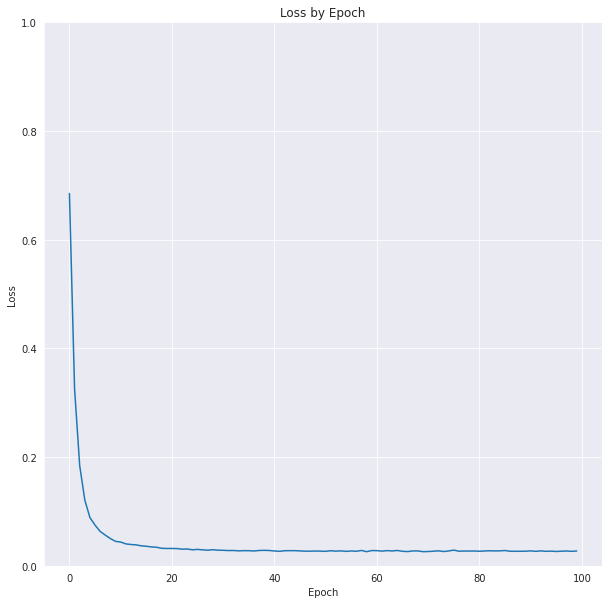

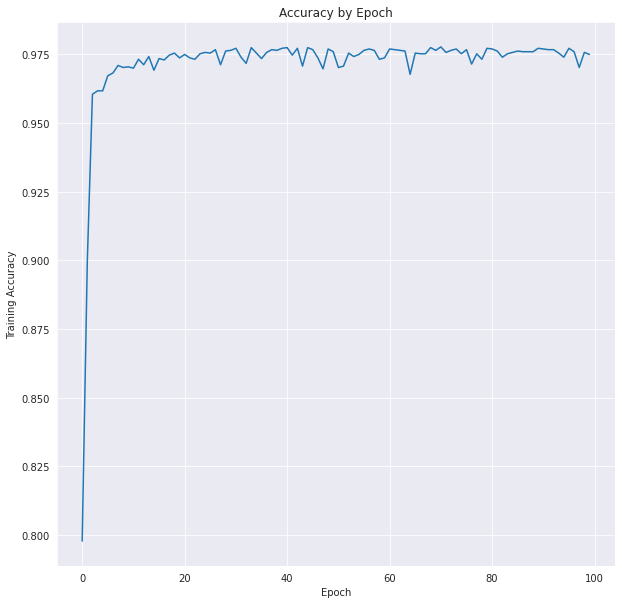

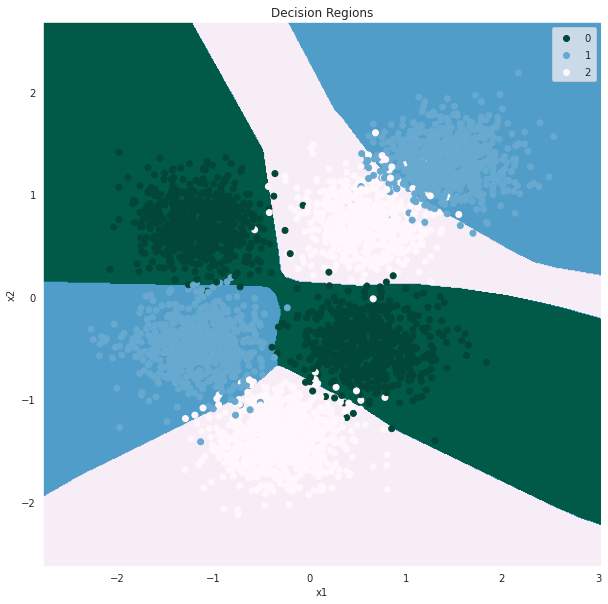

In [158]:
NN = MLP()
NN.add_layer('Hidden', dim_in=2, dim_out=16)
NN.add_layer('Hidden', dim_in=16, dim_out=16)
NN.add_layer('Hidden', dim_in=16, dim_out=16)
NN.add_layer('Output', dim_in=16, dim_out=3)
NN.add_layer('Loss', dim_in=3, dim_out=3)

loss = NN.train(X, y, epochs=100, bsize=8, alpha=0.0)
plot_loss(loss)
plot_accuracy(np.array(NN.train_accs),'Training Accuracy')
plot_decision_regions(NN)

#### Number of Hidden Units: 8

Network Training 

Number of Epochs:  100
Batch size:  8

Fitting data... 

Starting Epoch 1...
Finished Epochs 1-5.
Loss for Epoch 5: 0.11423924574146897
Starting Epoch 6...
Finished Epochs 6-10.
Loss for Epoch 10: 0.06564392129910139
Starting Epoch 11...
Finished Epochs 11-15.
Loss for Epoch 15: 0.05435264180639015
Starting Epoch 16...
Finished Epochs 16-20.
Loss for Epoch 20: 0.045214193369368924
Starting Epoch 21...
Finished Epochs 21-25.
Loss for Epoch 25: 0.04073081606059582
Starting Epoch 26...
Finished Epochs 26-30.
Loss for Epoch 30: 0.03592364911407635
Starting Epoch 31...
Finished Epochs 31-35.
Loss for Epoch 35: 0.033956686742051045
Starting Epoch 36...
Finished Epochs 36-40.
Loss for Epoch 40: 0.031624832654261095
Starting Epoch 41...
Finished Epochs 41-45.
Loss for Epoch 45: 0.030182062867075008
Starting Epoch 46...
Finished Epochs 46-50.
Loss for Epoch 50: 0.02875472000971516
Starting Epoch 51...
Finished Epochs 51-55.
Loss for Epoch 55: 0.028450842578643533
Starting Epo

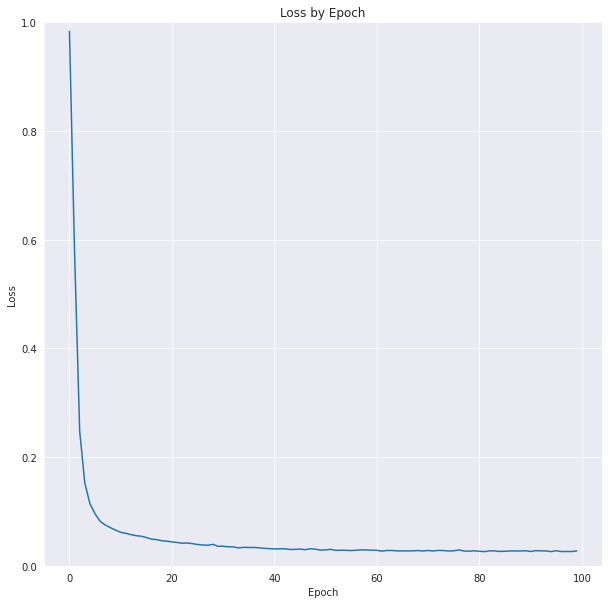

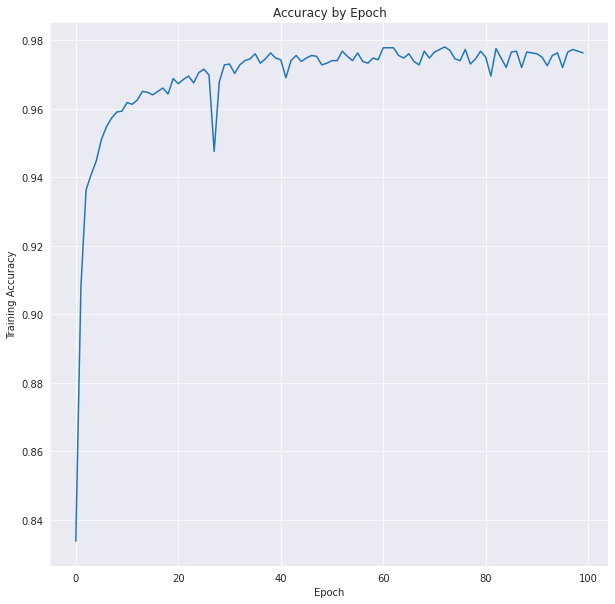

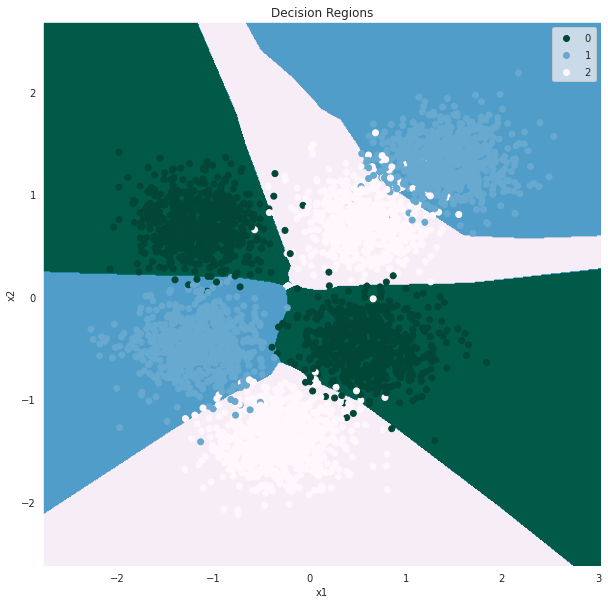

In [159]:
NN = MLP()
NN.add_layer('Hidden', dim_in=2, dim_out=8)
NN.add_layer('Hidden', dim_in=8, dim_out=8)
NN.add_layer('Hidden', dim_in=8, dim_out=8)
NN.add_layer('Output', dim_in=8, dim_out=3)
NN.add_layer('Loss', dim_in=3, dim_out=3)

loss = NN.train(X, y, epochs=100, bsize=8, alpha=0.0)
plot_loss(loss)
plot_accuracy(np.array(NN.train_accs),'Training Accuracy')
plot_decision_regions(NN)

#### Number of Hidden Units: 3

Network Training 

Number of Epochs:  100
Batch size:  8

Fitting data... 

Starting Epoch 1...
Finished Epochs 1-5.
Loss for Epoch 5: 0.5736128721476974
Starting Epoch 6...
Finished Epochs 6-10.
Loss for Epoch 10: 0.18939460339143943
Starting Epoch 11...
Finished Epochs 11-15.
Loss for Epoch 15: 0.08692133896851456
Starting Epoch 16...
Finished Epochs 16-20.
Loss for Epoch 20: 0.06821337403550333
Starting Epoch 21...
Finished Epochs 21-25.
Loss for Epoch 25: 0.06259828510123638
Starting Epoch 26...
Finished Epochs 26-30.
Loss for Epoch 30: 0.05972198727783714
Starting Epoch 31...
Finished Epochs 31-35.
Loss for Epoch 35: 0.057592418234625756
Starting Epoch 36...
Finished Epochs 36-40.
Loss for Epoch 40: 0.055792423172743695
Starting Epoch 41...
Finished Epochs 41-45.
Loss for Epoch 45: 0.05468364445585142
Starting Epoch 46...
Finished Epochs 46-50.
Loss for Epoch 50: 0.05457801383491214
Starting Epoch 51...
Finished Epochs 51-55.
Loss for Epoch 55: 0.053080224352188725
Starting Epoch 

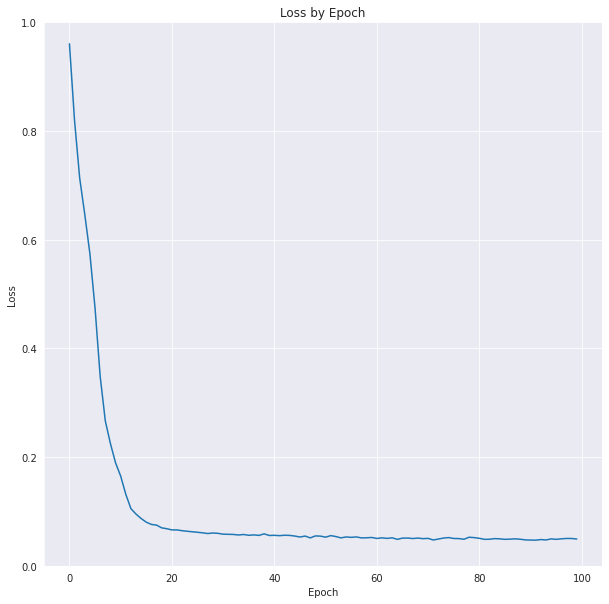

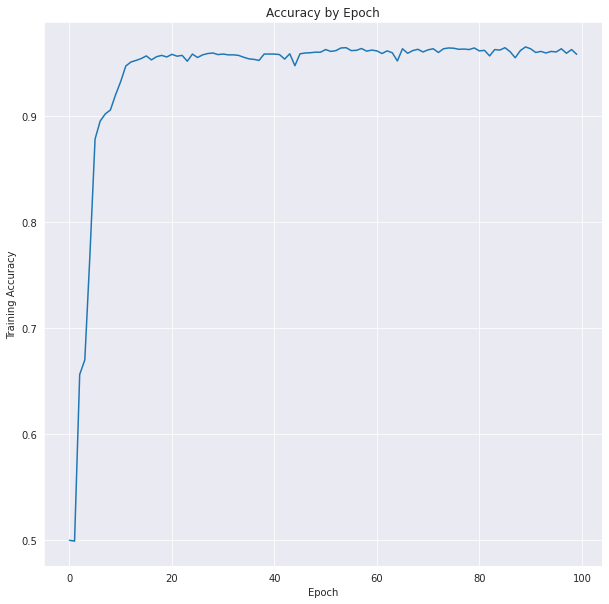

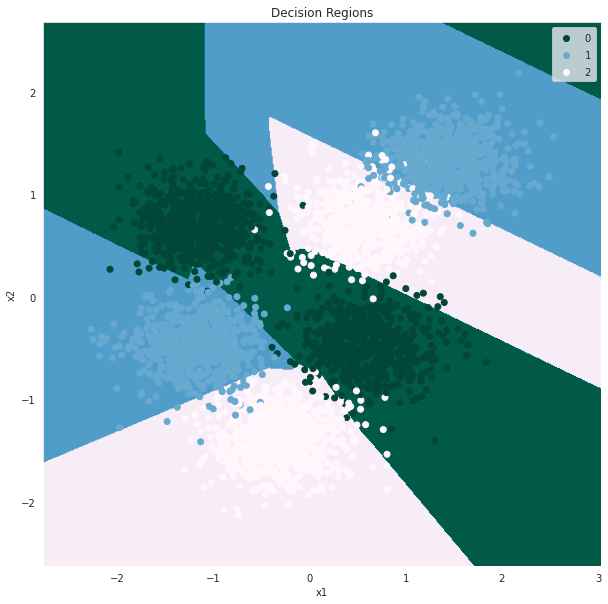

In [160]:
NN = MLP()
NN.add_layer('Hidden', dim_in=2, dim_out=3)
NN.add_layer('Hidden', dim_in=3, dim_out=3)
NN.add_layer('Hidden', dim_in=3, dim_out=3)
NN.add_layer('Output', dim_in=3, dim_out=3)
NN.add_layer('Loss', dim_in=3, dim_out=3)

loss = NN.train(X, y, epochs=100, bsize=8, alpha=0.0)
plot_loss(loss)
plot_accuracy(np.array(NN.train_accs),'Training Accuracy')
plot_decision_regions(NN)

### Number of Hidden Layers: 1

#### Number of Hidden Units: 16

Network Training 

Number of Epochs:  100
Batch size:  8

Fitting data... 

Starting Epoch 1...
Finished Epochs 1-5.
Loss for Epoch 5: 0.2971892135565231
Starting Epoch 6...
Finished Epochs 6-10.
Loss for Epoch 10: 0.15550875016330998
Starting Epoch 11...
Finished Epochs 11-15.
Loss for Epoch 15: 0.10714070062466756
Starting Epoch 16...
Finished Epochs 16-20.
Loss for Epoch 20: 0.08378779892075235
Starting Epoch 21...
Finished Epochs 21-25.
Loss for Epoch 25: 0.07026424185931876
Starting Epoch 26...
Finished Epochs 26-30.
Loss for Epoch 30: 0.06176861316567029
Starting Epoch 31...
Finished Epochs 31-35.
Loss for Epoch 35: 0.05568272735509833
Starting Epoch 36...
Finished Epochs 36-40.
Loss for Epoch 40: 0.0511155816110861
Starting Epoch 41...
Finished Epochs 41-45.
Loss for Epoch 45: 0.048238288845639715
Starting Epoch 46...
Finished Epochs 46-50.
Loss for Epoch 50: 0.045378658384832946
Starting Epoch 51...
Finished Epochs 51-55.
Loss for Epoch 55: 0.04307923685192116
Starting Epoch 56

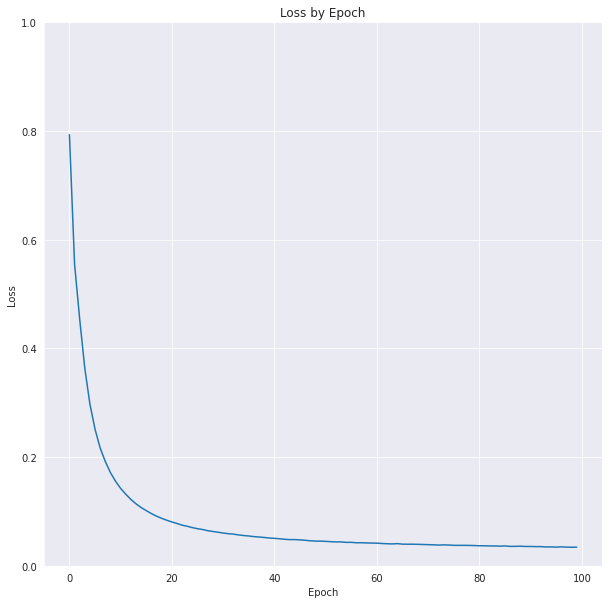

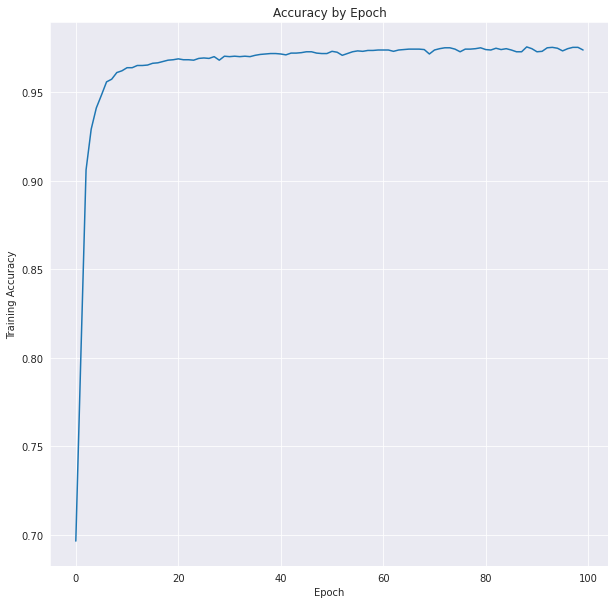

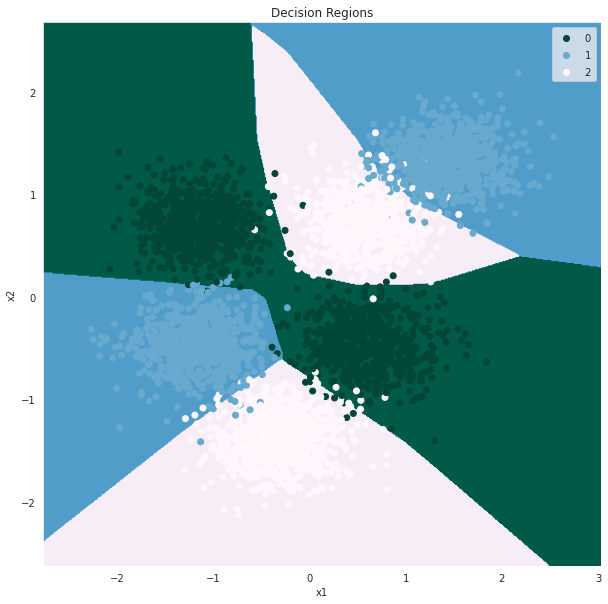

In [161]:
NN = MLP()
NN.add_layer('Hidden', dim_in=2, dim_out=16)
NN.add_layer('Output', dim_in=16, dim_out=3)
NN.add_layer('Loss', dim_in=3, dim_out=3)

loss = NN.train(X, y, epochs=100, bsize=8, alpha=0.0)
plot_loss(loss)
plot_accuracy(np.array(NN.train_accs),'Training Accuracy')
plot_decision_regions(NN)

#### Number of Hidden Units: 8

Network Training 

Number of Epochs:  100
Batch size:  8

Fitting data... 

Starting Epoch 1...
Finished Epochs 1-5.
Loss for Epoch 5: 0.3584367591236133
Starting Epoch 6...
Finished Epochs 6-10.
Loss for Epoch 10: 0.19642338317395253
Starting Epoch 11...
Finished Epochs 11-15.
Loss for Epoch 15: 0.12796532234377483
Starting Epoch 16...
Finished Epochs 16-20.
Loss for Epoch 20: 0.09655282800977139
Starting Epoch 21...
Finished Epochs 21-25.
Loss for Epoch 25: 0.0801664608478928
Starting Epoch 26...
Finished Epochs 26-30.
Loss for Epoch 30: 0.06977367777913432
Starting Epoch 31...
Finished Epochs 31-35.
Loss for Epoch 35: 0.06324361461524095
Starting Epoch 36...
Finished Epochs 36-40.
Loss for Epoch 40: 0.05784891067801531
Starting Epoch 41...
Finished Epochs 41-45.
Loss for Epoch 45: 0.05372498626624511
Starting Epoch 46...
Finished Epochs 46-50.
Loss for Epoch 50: 0.05128299175353656
Starting Epoch 51...
Finished Epochs 51-55.
Loss for Epoch 55: 0.04868027645968188
Starting Epoch 56..

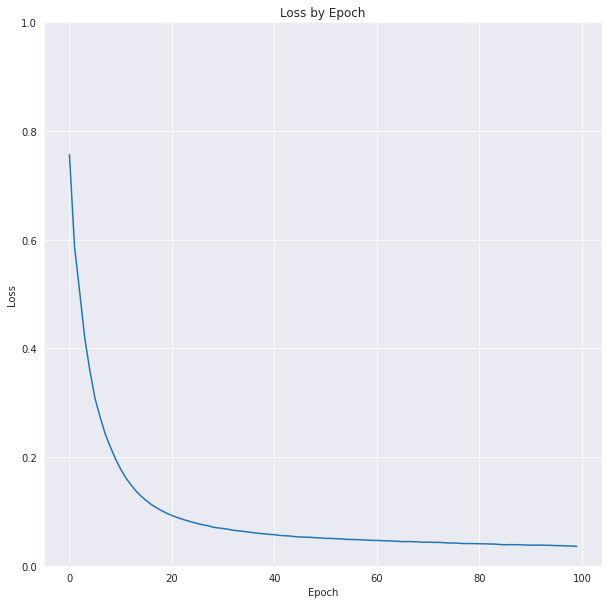

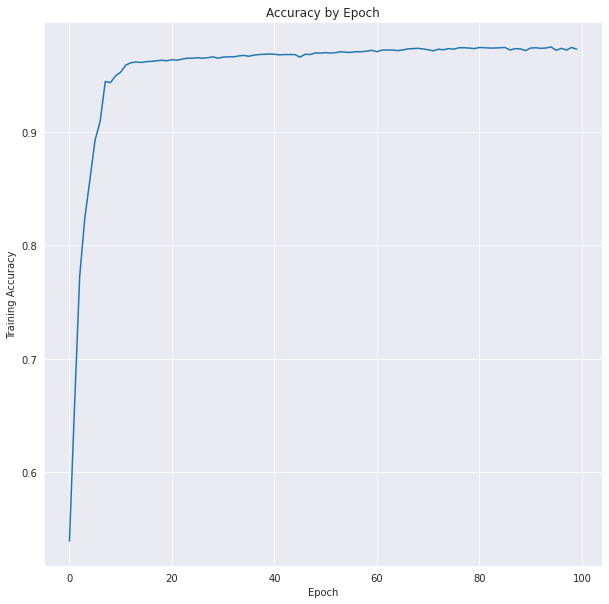

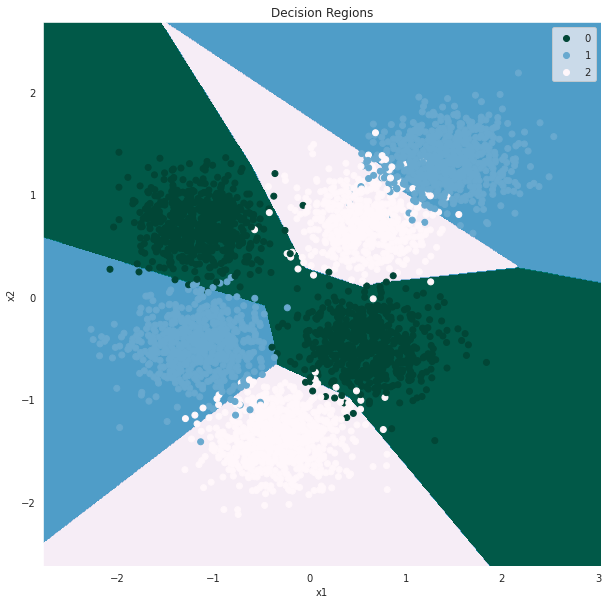

In [162]:
NN = MLP()
NN.add_layer('Hidden', dim_in=2, dim_out=8)
NN.add_layer('Output', dim_in=8, dim_out=3)
NN.add_layer('Loss', dim_in=3, dim_out=3)

loss = NN.train(X, y, epochs=100, bsize=8, alpha=0.0)
plot_loss(loss)
plot_accuracy(np.array(NN.train_accs),'Training Accuracy')
plot_decision_regions(NN)

#### Number of Hidden Units: 3

Network Training 

Number of Epochs:  100
Batch size:  8

Fitting data... 

Starting Epoch 1...
Finished Epochs 1-5.
Loss for Epoch 5: 0.43781835263230867
Starting Epoch 6...
Finished Epochs 6-10.
Loss for Epoch 10: 0.39238276829938834
Starting Epoch 11...
Finished Epochs 11-15.
Loss for Epoch 15: 0.23608632548804423
Starting Epoch 16...
Finished Epochs 16-20.
Loss for Epoch 20: 0.18968293543311732
Starting Epoch 21...
Finished Epochs 21-25.
Loss for Epoch 25: 0.16385813288285367
Starting Epoch 26...
Finished Epochs 26-30.
Loss for Epoch 30: 0.1474014444236393
Starting Epoch 31...
Finished Epochs 31-35.
Loss for Epoch 35: 0.13653189190583037
Starting Epoch 36...
Finished Epochs 36-40.
Loss for Epoch 40: 0.12818741829449595
Starting Epoch 41...
Finished Epochs 41-45.
Loss for Epoch 45: 0.12156891150460396
Starting Epoch 46...
Finished Epochs 46-50.
Loss for Epoch 50: 0.11623343910690911
Starting Epoch 51...
Finished Epochs 51-55.
Loss for Epoch 55: 0.11268836444776377
Starting Epoch 56.

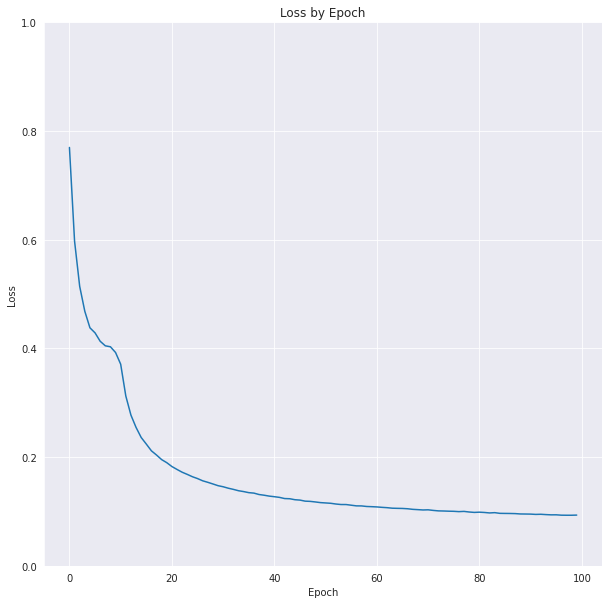

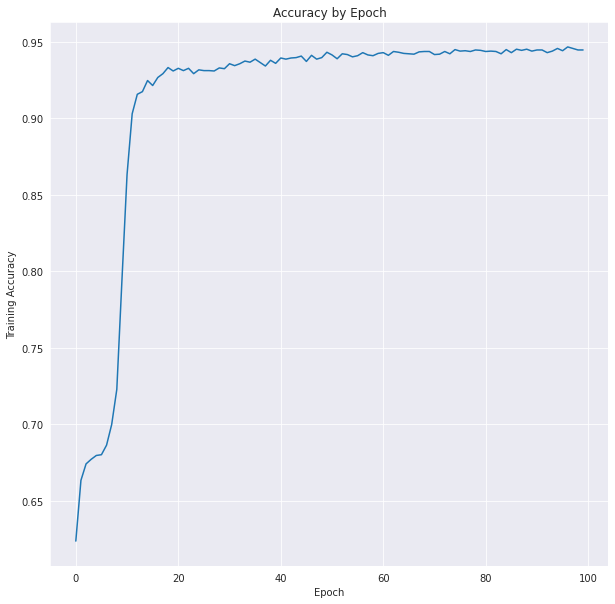

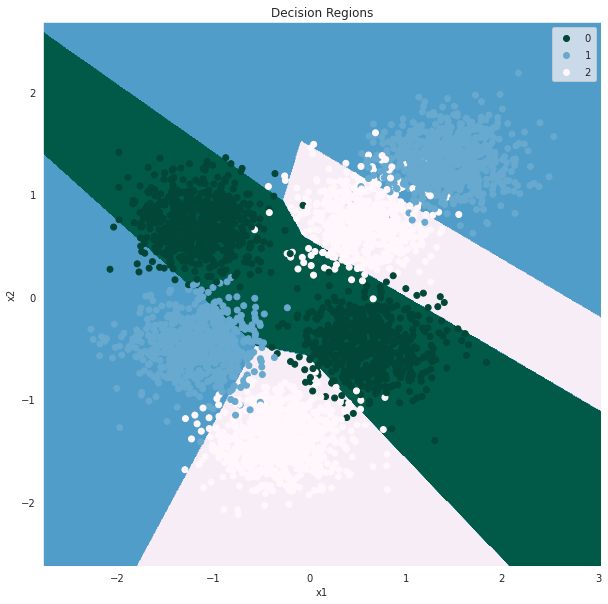

In [164]:
NN = MLP()
NN.add_layer('Hidden', dim_in=2, dim_out=3)
NN.add_layer('Output', dim_in=3, dim_out=3)
NN.add_layer('Loss', dim_in=3, dim_out=3)

loss = NN.train(X, y, epochs=100, bsize=8, alpha=0.0)
plot_loss(loss)
plot_accuracy(np.array(NN.train_accs),'Training Accuracy')
plot_decision_regions(NN)

## Regularization Value: 0.01

### Number of Hidden Layers: 3

#### Number of Hidden Units: 16

Network Training 

Number of Epochs:  100
Batch size:  8

Fitting data... 

Starting Epoch 1...
Finished Epochs 1-5.
Loss for Epoch 5: 0.40611494298004513
Starting Epoch 6...
Finished Epochs 6-10.
Loss for Epoch 10: 0.38392814586408197
Starting Epoch 11...
Finished Epochs 11-15.
Loss for Epoch 15: 0.3815232201749191
Starting Epoch 16...
Finished Epochs 16-20.
Loss for Epoch 20: 0.37940056122268817
Starting Epoch 21...
Finished Epochs 21-25.
Loss for Epoch 25: 0.37353772179027056
Starting Epoch 26...
Finished Epochs 26-30.
Loss for Epoch 30: 0.36705272693686286
Starting Epoch 31...
Finished Epochs 31-35.
Loss for Epoch 35: 0.36265927116101615
Starting Epoch 36...
Finished Epochs 36-40.
Loss for Epoch 40: 0.35794598384267023
Starting Epoch 41...
Finished Epochs 41-45.
Loss for Epoch 45: 0.35084432973495916
Starting Epoch 46...
Finished Epochs 46-50.
Loss for Epoch 50: 0.3480586890279851
Starting Epoch 51...
Finished Epochs 51-55.
Loss for Epoch 55: 0.34254813870544704
Starting Epoch 56..

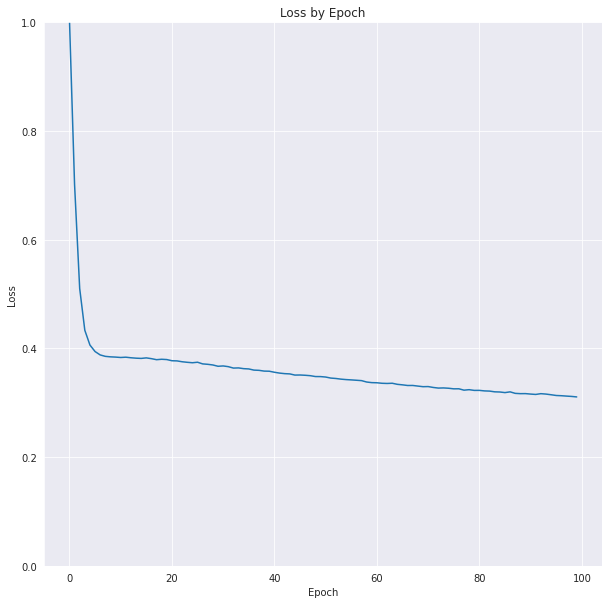

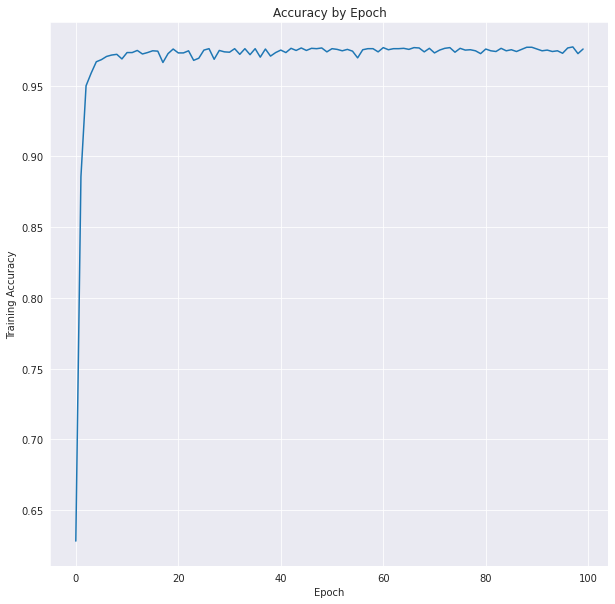

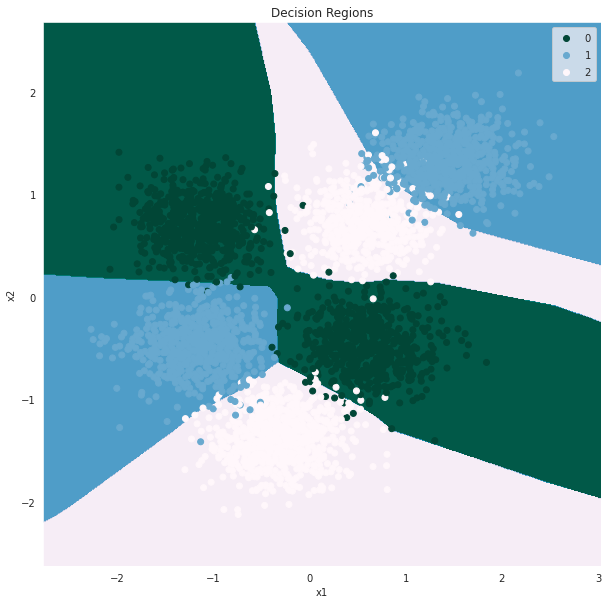

In [165]:
NN = MLP()
NN.add_layer('Hidden', dim_in=2, dim_out=16)
NN.add_layer('Hidden', dim_in=16, dim_out=16)
NN.add_layer('Hidden', dim_in=16, dim_out=16)
NN.add_layer('Output', dim_in=16, dim_out=3)
NN.add_layer('Loss', dim_in=3, dim_out=3)

loss = NN.train(X, y, epochs=100, bsize=8, alpha=0.01)
plot_loss(loss)
plot_accuracy(np.array(NN.train_accs),'Training Accuracy')
plot_decision_regions(NN)

#### Number of Hidden Units: 8

Network Training 

Number of Epochs:  100
Batch size:  8

Fitting data... 

Starting Epoch 1...
Finished Epochs 1-5.
Loss for Epoch 5: 0.36756613838400565
Starting Epoch 6...
Finished Epochs 6-10.
Loss for Epoch 10: 0.3454670848247022
Starting Epoch 11...
Finished Epochs 11-15.
Loss for Epoch 15: 0.3461121519707217
Starting Epoch 16...
Finished Epochs 16-20.
Loss for Epoch 20: 0.3490595036337644
Starting Epoch 21...
Finished Epochs 21-25.
Loss for Epoch 25: 0.347608895963484
Starting Epoch 26...
Finished Epochs 26-30.
Loss for Epoch 30: 0.343068738155283
Starting Epoch 31...
Finished Epochs 31-35.
Loss for Epoch 35: 0.34088104245802714
Starting Epoch 36...
Finished Epochs 36-40.
Loss for Epoch 40: 0.34002616841538347
Starting Epoch 41...
Finished Epochs 41-45.
Loss for Epoch 45: 0.3367327618662523
Starting Epoch 46...
Finished Epochs 46-50.
Loss for Epoch 50: 0.3346724414625627
Starting Epoch 51...
Finished Epochs 51-55.
Loss for Epoch 55: 0.33179063567232775
Starting Epoch 56...
Finis

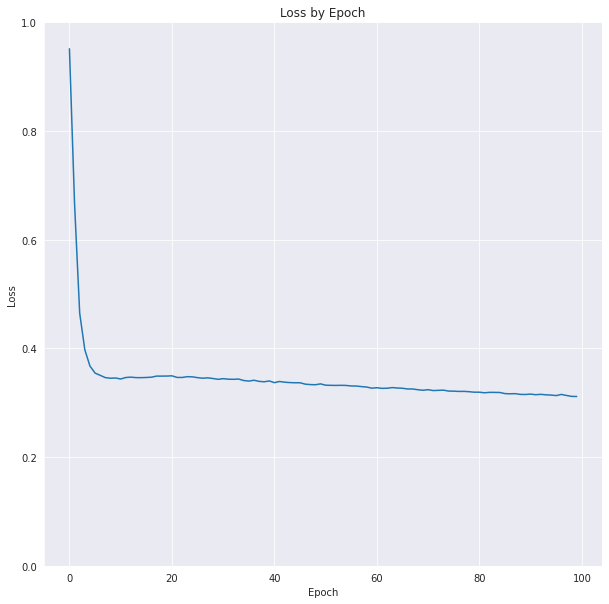

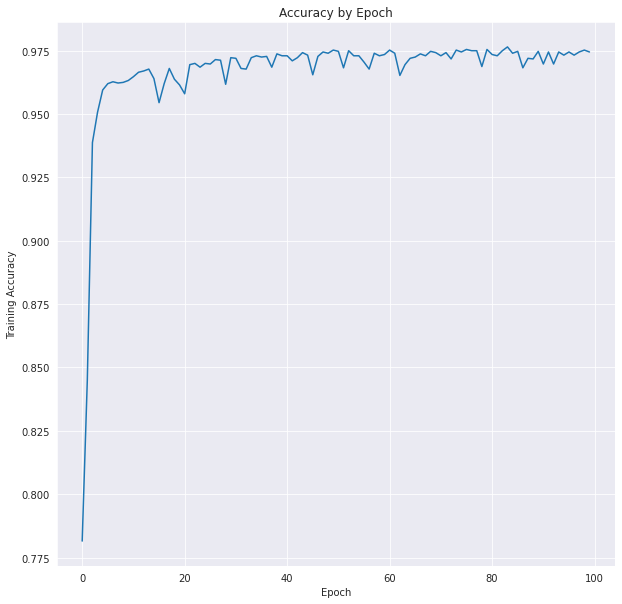

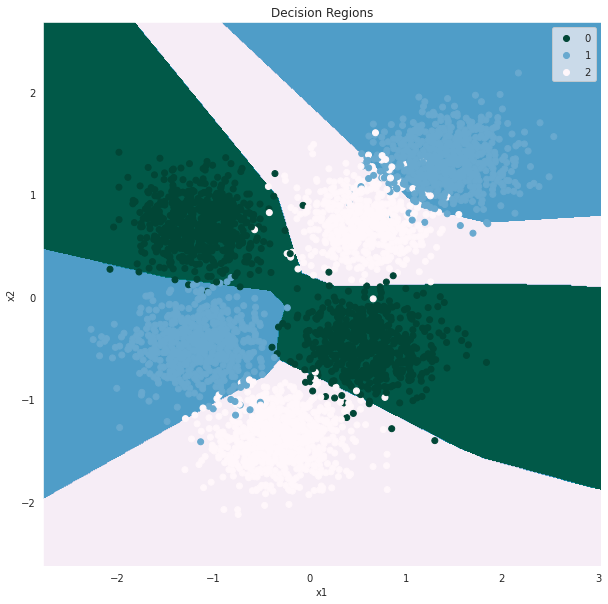

In [167]:
NN = MLP()
NN.add_layer('Hidden', dim_in=2, dim_out=8)
NN.add_layer('Hidden', dim_in=8, dim_out=8)
NN.add_layer('Hidden', dim_in=8, dim_out=8)
NN.add_layer('Output', dim_in=8, dim_out=3)
NN.add_layer('Loss', dim_in=3, dim_out=3)

loss = NN.train(X, y, epochs=100, bsize=8, alpha=0.01)
plot_loss(loss)
plot_accuracy(np.array(NN.train_accs),'Training Accuracy')
plot_decision_regions(NN)

#### Number of Hidden Units: 3

Network Training 

Number of Epochs:  100
Batch size:  8

Fitting data... 

Starting Epoch 1...
Finished Epochs 1-5.
Loss for Epoch 5: 0.7381199779272444
Starting Epoch 6...
Finished Epochs 6-10.
Loss for Epoch 10: 0.37259919752639803
Starting Epoch 11...
Finished Epochs 11-15.
Loss for Epoch 15: 0.3366056789052457
Starting Epoch 16...
Finished Epochs 16-20.
Loss for Epoch 20: 0.33543537505156257
Starting Epoch 21...
Finished Epochs 21-25.
Loss for Epoch 25: 0.3373700487916085
Starting Epoch 26...
Finished Epochs 26-30.
Loss for Epoch 30: 0.335438374115746
Starting Epoch 31...
Finished Epochs 31-35.
Loss for Epoch 35: 0.3374576488604583
Starting Epoch 36...
Finished Epochs 36-40.
Loss for Epoch 40: 0.3382144849091678
Starting Epoch 41...
Finished Epochs 41-45.
Loss for Epoch 45: 0.3387461192168622
Starting Epoch 46...
Finished Epochs 46-50.
Loss for Epoch 50: 0.34002854551120537
Starting Epoch 51...
Finished Epochs 51-55.
Loss for Epoch 55: 0.3427102380489495
Starting Epoch 56...
Finis

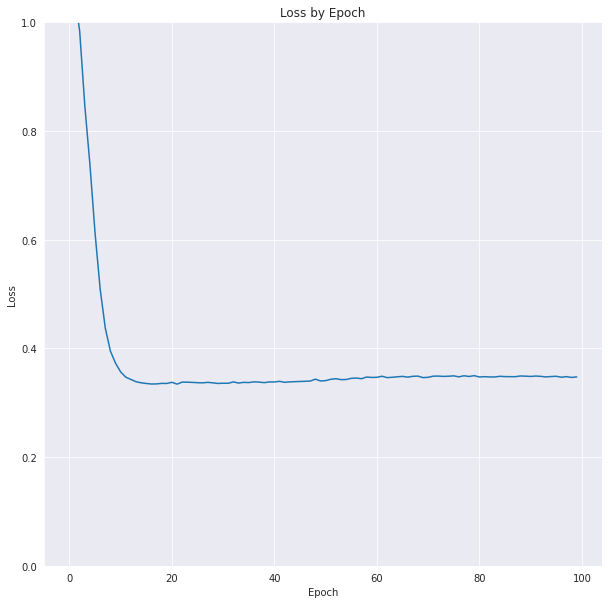

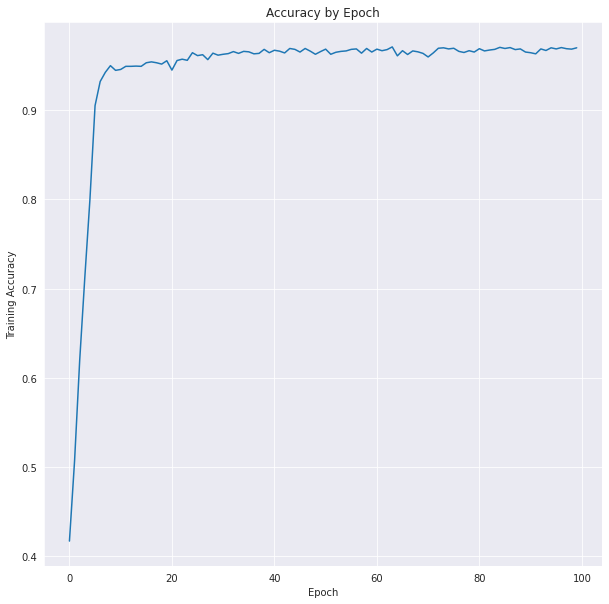

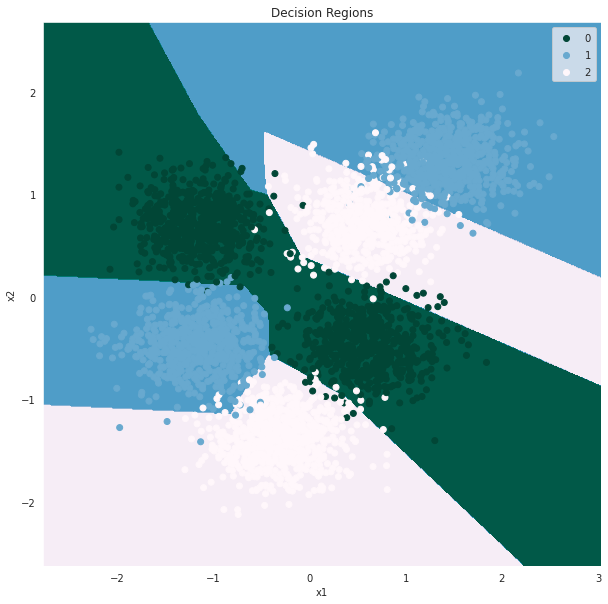

In [168]:
NN = MLP()
NN.add_layer('Hidden', dim_in=2, dim_out=3)
NN.add_layer('Hidden', dim_in=3, dim_out=3)
NN.add_layer('Hidden', dim_in=3, dim_out=3)
NN.add_layer('Output', dim_in=3, dim_out=3)
NN.add_layer('Loss', dim_in=3, dim_out=3)

loss = NN.train(X, y, epochs=100, bsize=8, alpha=0.01)
plot_loss(loss)
plot_accuracy(np.array(NN.train_accs),'Training Accuracy')
plot_decision_regions(NN)

### Number of Hidden Layers: 1

#### Number of Hidden Units: 16

Network Training 

Number of Epochs:  100
Batch size:  8

Fitting data... 

Starting Epoch 1...
Finished Epochs 1-5.
Loss for Epoch 5: 0.44449016880939984
Starting Epoch 6...
Finished Epochs 6-10.
Loss for Epoch 10: 0.4023670665269492
Starting Epoch 11...
Finished Epochs 11-15.
Loss for Epoch 15: 0.4127337787328471
Starting Epoch 16...
Finished Epochs 16-20.
Loss for Epoch 20: 0.4290111366826085
Starting Epoch 21...
Finished Epochs 21-25.
Loss for Epoch 25: 0.44401089529806004
Starting Epoch 26...
Finished Epochs 26-30.
Loss for Epoch 30: 0.45602069241062787
Starting Epoch 31...
Finished Epochs 31-35.
Loss for Epoch 35: 0.46642226929562564
Starting Epoch 36...
Finished Epochs 36-40.
Loss for Epoch 40: 0.47441756510179267
Starting Epoch 41...
Finished Epochs 41-45.
Loss for Epoch 45: 0.4806662101969838
Starting Epoch 46...
Finished Epochs 46-50.
Loss for Epoch 50: 0.4855205046905434
Starting Epoch 51...
Finished Epochs 51-55.
Loss for Epoch 55: 0.48908725098992445
Starting Epoch 56...
F

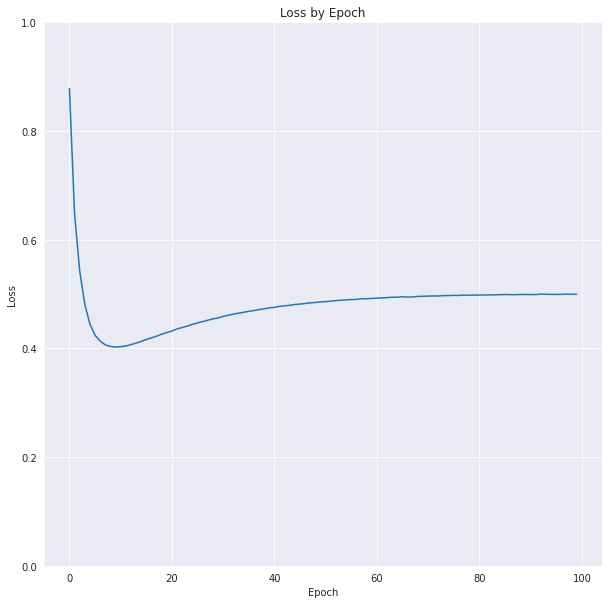

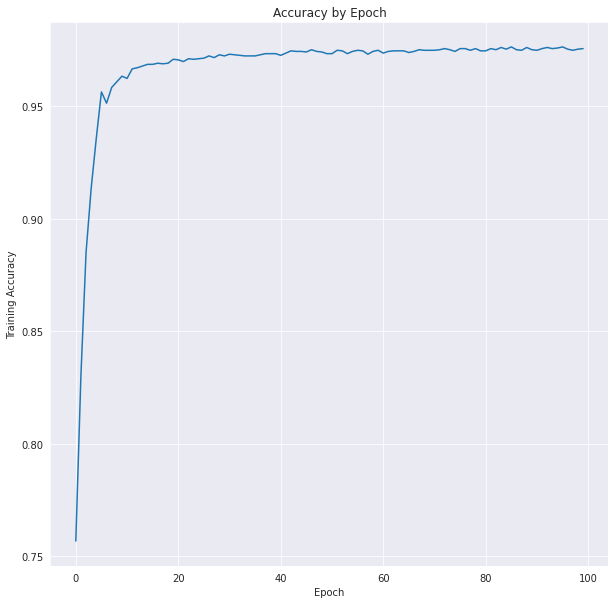

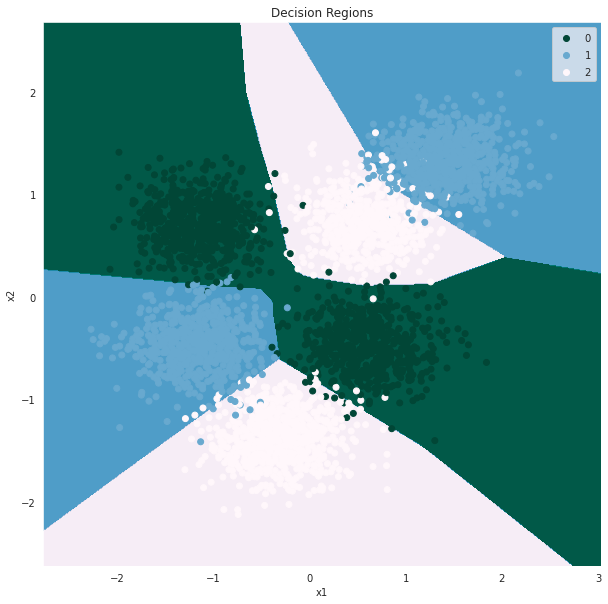

In [169]:
NN = MLP()
NN.add_layer('Hidden', dim_in=2, dim_out=16)
NN.add_layer('Output', dim_in=16, dim_out=3)
NN.add_layer('Loss', dim_in=3, dim_out=3)

loss = NN.train(X, y, epochs=100, bsize=8, alpha=0.01)
plot_loss(loss)
plot_accuracy(np.array(NN.train_accs),'Training Accuracy')
plot_decision_regions(NN)

#### Number of Hidden Units: 8

Network Training 

Number of Epochs:  100
Batch size:  8

Fitting data... 

Starting Epoch 1...
Finished Epochs 1-5.
Loss for Epoch 5: 0.4485330400361085
Starting Epoch 6...
Finished Epochs 6-10.
Loss for Epoch 10: 0.4061972122744352
Starting Epoch 11...
Finished Epochs 11-15.
Loss for Epoch 15: 0.41205412025924104
Starting Epoch 16...
Finished Epochs 16-20.
Loss for Epoch 20: 0.4215036192514311
Starting Epoch 21...
Finished Epochs 21-25.
Loss for Epoch 25: 0.4327081538606784
Starting Epoch 26...
Finished Epochs 26-30.
Loss for Epoch 30: 0.4431219610088151
Starting Epoch 31...
Finished Epochs 31-35.
Loss for Epoch 35: 0.45301899856361494
Starting Epoch 36...
Finished Epochs 36-40.
Loss for Epoch 40: 0.46105433781783356
Starting Epoch 41...
Finished Epochs 41-45.
Loss for Epoch 45: 0.468269751704651
Starting Epoch 46...
Finished Epochs 46-50.
Loss for Epoch 50: 0.4749517031403046
Starting Epoch 51...
Finished Epochs 51-55.
Loss for Epoch 55: 0.4795448590211005
Starting Epoch 56...
Finis

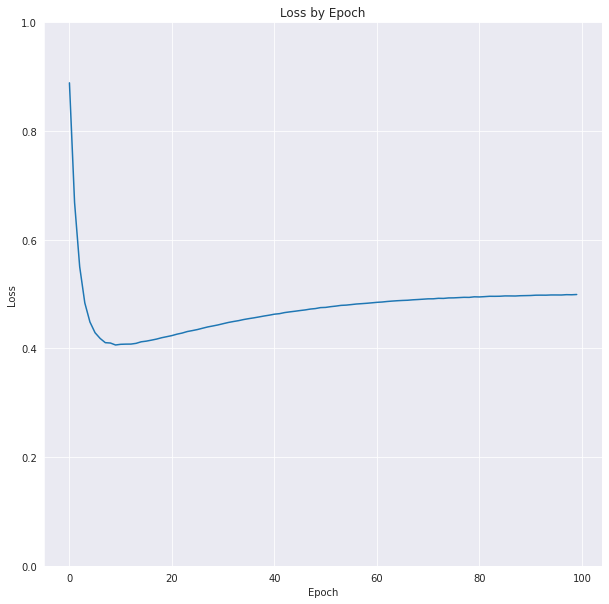

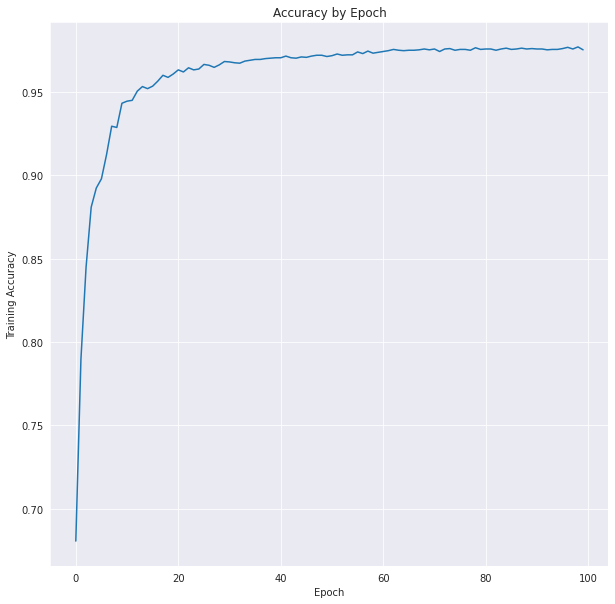

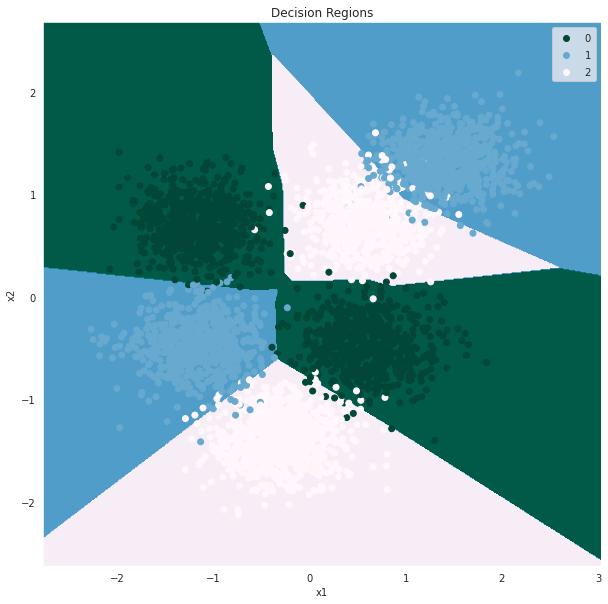

In [170]:
NN = MLP()
NN.add_layer('Hidden', dim_in=2, dim_out=8)
NN.add_layer('Output', dim_in=8, dim_out=3)
NN.add_layer('Loss', dim_in=3, dim_out=3)

loss = NN.train(X, y, epochs=100, bsize=8, alpha=0.01)
plot_loss(loss)
plot_accuracy(np.array(NN.train_accs),'Training Accuracy')
plot_decision_regions(NN)

#### Number of Hidden Units: 3

Network Training 

Number of Epochs:  100
Batch size:  8

Fitting data... 

Starting Epoch 1...
Finished Epochs 1-5.
Loss for Epoch 5: 0.5811672923379699
Starting Epoch 6...
Finished Epochs 6-10.
Loss for Epoch 10: 0.4376205111744161
Starting Epoch 11...
Finished Epochs 11-15.
Loss for Epoch 15: 0.4133124997901048
Starting Epoch 16...
Finished Epochs 16-20.
Loss for Epoch 20: 0.41608461890917414
Starting Epoch 21...
Finished Epochs 21-25.
Loss for Epoch 25: 0.424348686059632
Starting Epoch 26...
Finished Epochs 26-30.
Loss for Epoch 30: 0.43253616340373446
Starting Epoch 31...
Finished Epochs 31-35.
Loss for Epoch 35: 0.44115070931561495
Starting Epoch 36...
Finished Epochs 36-40.
Loss for Epoch 40: 0.44701918275479063
Starting Epoch 41...
Finished Epochs 41-45.
Loss for Epoch 45: 0.4541226794801932
Starting Epoch 46...
Finished Epochs 46-50.
Loss for Epoch 50: 0.46003017483384256
Starting Epoch 51...
Finished Epochs 51-55.
Loss for Epoch 55: 0.46508637600125885
Starting Epoch 56...
Fi

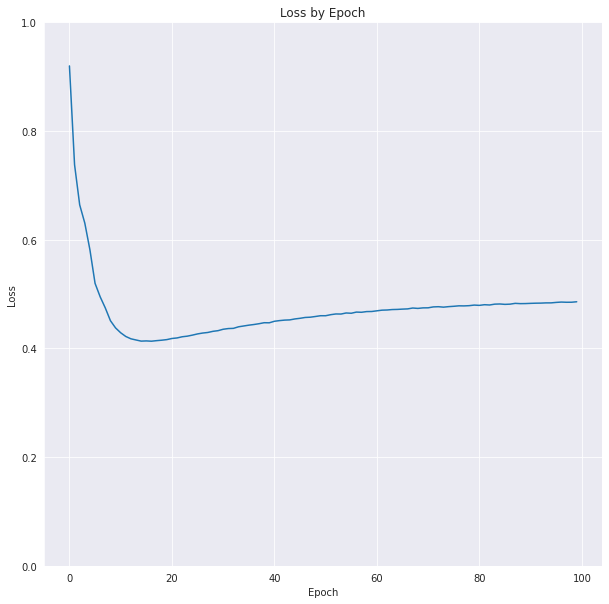

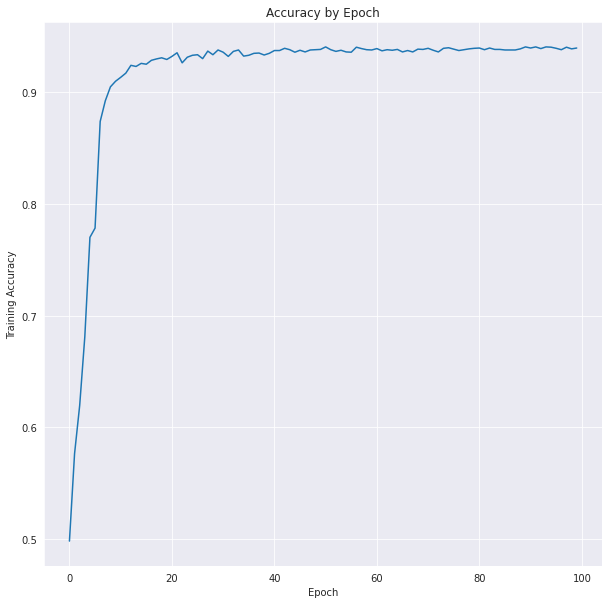

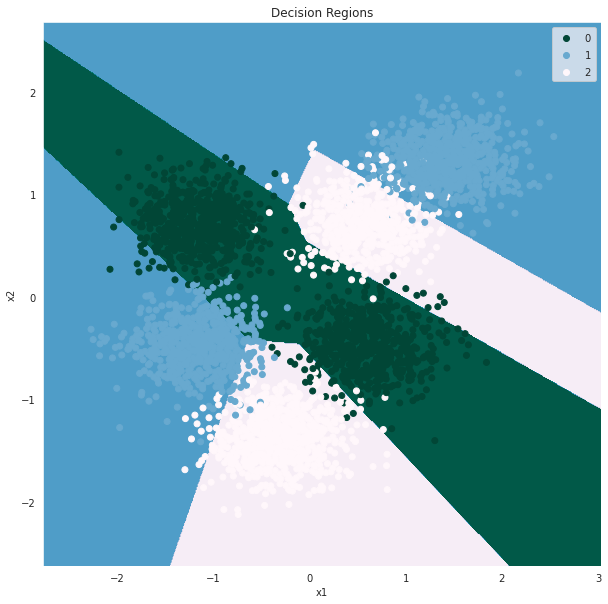

In [171]:
NN = MLP()
NN.add_layer('Hidden', dim_in=2, dim_out=3)
NN.add_layer('Output', dim_in=3, dim_out=3)
NN.add_layer('Loss', dim_in=3, dim_out=3)

loss = NN.train(X, y, epochs=100, bsize=8, alpha=0.01)
plot_loss(loss)
plot_accuracy(np.array(NN.train_accs),'Training Accuracy')
plot_decision_regions(NN)

# New Data

## Load Iris Dataset

In [172]:
iris = load_iris()
# Load data into a DataFrame
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
# Convert datatype to float
iris_df = iris_df.astype(float)
# append "target" and name it "label"
iris_df['label'] = iris.target
# Use string label instead
iris_df['label'] = iris_df.label.replace(dict(enumerate(iris.target_names)))

iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [173]:
# one hot encoding for labels
label = pd.get_dummies(iris_df['label'], prefix='label')
iris_df = pd.concat([iris_df, label], axis=1)
# drop old labels
iris_df.drop(['label'], axis=1, inplace=True)

iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label_setosa,label_versicolor,label_virginica
0,5.1,3.5,1.4,0.2,1,0,0
1,4.9,3.0,1.4,0.2,1,0,0
2,4.7,3.2,1.3,0.2,1,0,0
3,4.6,3.1,1.5,0.2,1,0,0
4,5.0,3.6,1.4,0.2,1,0,0


In [174]:
# Create input arrays
iris_X = iris_df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']]
iris_X = np.asarray(iris_X)
iris_y_onehot = iris_df[['label_setosa', 'label_versicolor', 'label_virginica']]
iris_y_onehot = np.asarray(iris_y_onehot)
iris_y = np.argmax(iris_y_onehot, axis=1).astype(int)

# Train Network with Early Stopping

After splitting the data into Train, Validation, and Test sets, I use the 
training set to train the network, validation set for early stopping, and 
test set for classification accuracy.

Network Training 

Number of Epochs:  100
Batch size:  8

Fitting data... 

Starting Epoch 1...
Finished Epochs 1-5.
Loss for Epoch 5: 1.198745581930119
Starting Epoch 6...
Finished Epochs 6-10.
Loss for Epoch 10: 1.0836024945075455
Starting Epoch 11...
Finished Epochs 11-15.
Loss for Epoch 15: 0.9180304755789866
Starting Epoch 16...
Finished Epochs 16-20.
Loss for Epoch 20: 0.6218628260066484
Starting Epoch 21...
Finished Epochs 21-25.
Loss for Epoch 25: 0.5853495619816883
Starting Epoch 26...
Finished Epochs 26-30.
Loss for Epoch 30: 0.5056599125790895

Stopping training early to prevent overfitting
Training Complete 

Training Accuracy: 95.24%
Validation Accuracy: 95.45%


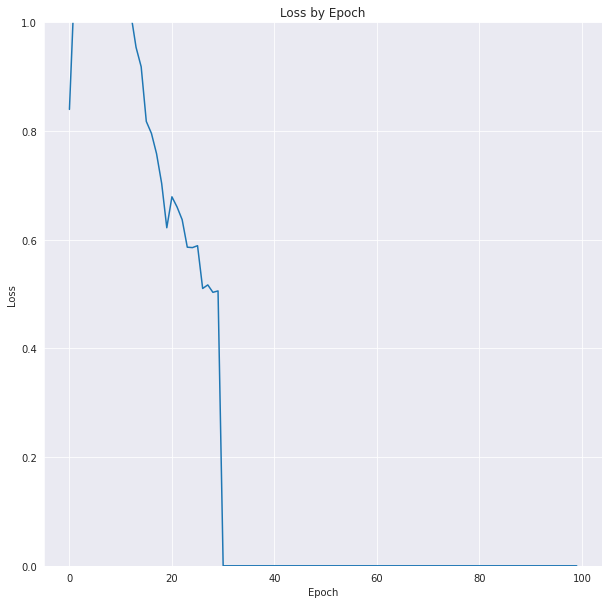

In [190]:
NN = MLP()
NN.add_layer('Hidden', dim_in=4, dim_out=16)
NN.add_layer('Hidden', dim_in=16, dim_out=16)
NN.add_layer('Hidden', dim_in=16, dim_out=16)
NN.add_layer('Output', dim_in=16, dim_out=3)
NN.add_layer('Loss', dim_in=3, dim_out=3)

loss = NN.train(iris_X, iris_y, epochs=100, bsize=8, alpha=0.01, early_stopping=True)
plot_loss(loss)

## Accuracy of Network

In [178]:
test_preds = NN.predict(NN.X_test)
test_real = np.argmax(NN.y_test, axis=1).astype(int)
test_acc = np.mean(np.equal(test_preds,test_real))
print('Accuracy: ' + '{:.2f}'.format(test_acc*100) + '%')

Accuracy: 91.30%
